# MATH50003 (2022–23)
# Lab 3: Divided differences and dual numbers

This lab explores different discretisations for first and higher derivatives.
In particular we consider the following approximations:
*Forward differences*:
$$
f'(x) ≈ {f(x+h) - f(x) \over h}
$$
*Central differences*:
$$
f'(x) ≈ {f(x+h) - f(x-h) \over 2h}
$$
*Second order differences*:
$$
f''(x) ≈ {f(x+h) - 2f(x) + f(x-h) \over h^2}
$$
We also add to the implementation of `Dual` to enable
automatic differentiation with cos, sin, and division

In [2]:
using Plots, Test
# helper function to avoid trying to take logs of 0 in plots
# use in plots below
nanabs(x) = iszero(x) ? NaN : abs(x)

nanabs (generic function with 1 method)

--------

**Problem 1** Implement central differences
for $f(x) = 1 + x + x^2$ and $g(x) = 1 + x/3 + x^2$, approximating the derivative at $x = 0$.
Plot the absolute errors for `h = 2.0 .^ (0:-1:-60)` and `h = 10.0 .^ (0:-1:-16)`.

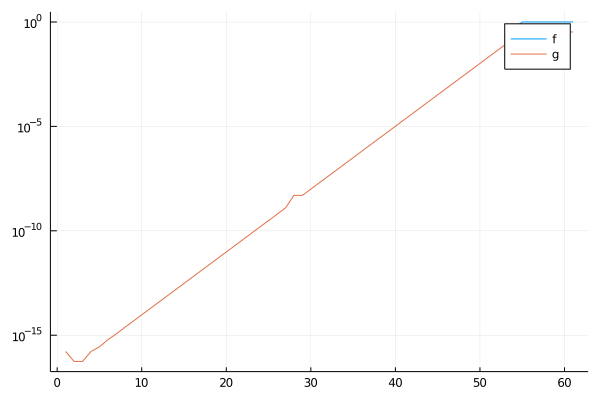

In [22]:
f = x -> 1 + x + x^2
g = x -> 1 + x/3 + x^2

fprime = x -> 1 + 2 *x
gprime = x ->1/3 + 2 *x

centraldiff(x, h, f) = (f(x + h) - f(x - h))/(2 *h)

centraldifferror(x, h, f, fprime) = abs(centraldiff(x, h, f) - fprime(x))


x = 0.0

h = 2.0 .^ (0:-1:-60)
plot(nanabs.(centraldifferror.(x, h, f, fprime)), yaxis=:log10, label="f")
plot!(nanabs.(centraldifferror.(x, h, g, gprime)), yaxis=:log10, label="g")

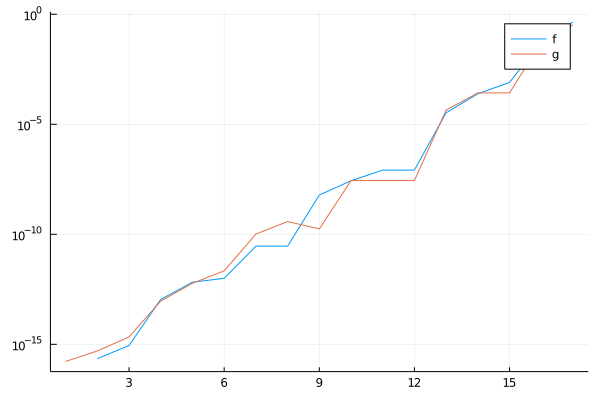

In [23]:
h = 10.0 .^ (0:-1:-16)
plot(nanabs.(centraldifferror.(x, h, f, fprime)), yaxis=:log10, label="f")
plot!(nanabs.(centraldifferror.(x, h, g, gprime)), yaxis=:log10, label="g")

-----
**Problem 2** Use forward differences, central differences, and second-order divided differences to approximate to 5-digits the first and second
derivatives to the following functions
at the point $x = 0.1$:
$$
\exp(\exp x \cos x + \sin x), ∏_{k=1}^{1000} \left({x \over k}-1\right), \hbox{ and } f^{\rm s}_{1000}(x)
$$
where $f^{\rm s}_n(x)$ corresponds to $n$-terms of the following continued fraction:
$$
1 + {x-1 \over 2 + {x-1 \over 2 + {x-1 \over 2 + ⋱}}},
$$
e.g.:
$$f^{\rm s}_1(x) = 1 + {x-1 \over 2}$$
$$f^{\rm s}_2(x) = 1 + {x-1 \over 2 + {x -1 \over 2}}$$
$$f^{\rm s}_3(x) = 1 + {x-1 \over 2 + {x -1 \over 2 + {x-1 \over 2}}}$$

In [52]:
forwarddiff(x, h, f) = (f(x + h) - f(x)) / h
seconddiff(x, h, f) = (f(x + h) - 2f(x) + f(x - h))/ h^2
x = 0.1

f = x -> exp(exp(x)cos(x) + sin(x))
g = x -> prod([x] ./ (1:1000) .- 1)

function s(x)
    top = (x - 1)
    bottom = 2
    for i in (1, 1000)
        bottom = 2 + top/bottom
    end
    1 + top/bottom
end

function cont(n, x)
    ret = 2*one(x)
    for k = 1:n-1
        ret = 2 + (x-1)/ret
    end
    1 + (x-1)/ret
end

println("f'($x) with forward difference: ", forwarddiff(x, sqrt(eps()), f))
println("f'($x) with central difference: ", centraldiff(x, sqrt(eps()), f))
println("f''($x) via divided difference:  ",seconddiff(x, cbrt(eps()), f))

println("g'($x) with forward difference: ", forwarddiff(x, sqrt(eps()), g))
println("g'($x) with central difference: ", centraldiff(x, sqrt(eps()), g))
println("g''($x) via divided difference:  ",
seconddiff(x, cbrt(eps()), g))

println("s'($x) with forward difference: ", forwarddiff(x, sqrt(eps()), x->cont(1000,x)))
println("s'($x) with central difference: ", centraldiff(x, sqrt(eps()), x->cont(1000,x)))
println("s''($x) via divided difference:  ",
seconddiff(x, cbrt(eps()), x->cont(1000,x)))

f'(0.1) with forward difference: 6.58477258682251
f'(0.1) with central difference: 6.584772557020187
f''(0.1) via divided difference:  12.002685822813502
g'(0.1) with forward difference: -3.5938263945281506
g'(0.1) with central difference: -3.593826537951827
g''(0.1) via divided difference:  26.638555736977985
s'(0.1) with forward difference: 1.5811387598514557
s'(0.1) with central difference: 1.5811388231813908
s''(0.1) via divided difference:  -7.905698560322122


----

**Problem 3.1** Add support for `cos`, `sin`, and `/` to the type `Dual`:

In [58]:
# Dual(a,b) represents a + b*ϵ
struct Dual{T}
    a::T
    b::T
end

# Dual(a) represents a + 0*ϵ
Dual(a::Real) = Dual(a, zero(a)) # for real numbers we use a + 0ϵ

# Allow for a + b*ϵ syntax
const ϵ = Dual(0, 1)

import Base: +, *, -, /, ^, zero, exp, cos, sin, one

# support polynomials like 1 + x, x - 1, 2x or x*2 by reducing to Dual
+(x::Real, y::Dual) = Dual(x) + y
+(x::Dual, y::Real) = x + Dual(y)
-(x::Real, y::Dual) = Dual(x) - y
-(x::Dual, y::Real) = x - Dual(y)
*(x::Real, y::Dual) = Dual(x) * y
*(x::Dual, y::Real) = x * Dual(y)

# support x/2 (but not yet division of duals)
/(x::Dual, k::Real) = Dual(x.a/k, x.b/k)

# a simple recursive function to support x^2, x^3, etc.
function ^(x::Dual, k::Integer)
    if k < 0
        error("Not implemented")
    elseif k == 1
        x
    else
        x^(k-1) * x
    end
end

# support identity of type Dual
one(x::Dual) = Dual(one(eltype(x.a)))

# Algebraic operations for duals
-(x::Dual) = Dual(-x.a, -x.b)
+(x::Dual, y::Dual) = Dual(x.a + y.a, x.b + y.b)
-(x::Dual, y::Dual) = Dual(x.a - y.a, x.b - y.b)
*(x::Dual, y::Dual) = Dual(x.a*y.a, x.a*y.b + x.b*y.a)

exp(x::Dual) = Dual(exp(x.a), exp(x.a) * x.b)

function cos(x::Dual)
    cos(x.a) - x.b * sin(x.a) * ϵ
end

function sin(x::Dual)
    sin(x.a) + x.b * cos(x.a) * ϵ
end

function /(x::Dual, y::Dual)
    x.a / y.a + ϵ *((x.b * y.a - x.a * y.b) / y.a ^ 2)

end

x = 0.1
@test cos(sin(x+ϵ)/(x+ϵ)).b ≈ -((cos(x)/x - sin(x)/x^2)sin(sin(x)/x))

Test Passed

**Problem 3.2** Use dual numbers to compute the derivatives to
$$
\exp(\exp x \cos x + \sin x), ∏_{k=1}^{1000} \left({x \over k}-1\right), \hbox{ and } f^{\rm s}_{1000}(x).
$$
Does your answer match (to 5 digits) Problem 2?

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*